In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# lets import some stuff
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re
from keras import regularizers
import matplotlib.pyplot as plt
import os
%matplotlib inline
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from matplotlib import*
from plot_keras_history import show_history, plot_history
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# confirm  the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

NVIDIA GeForce RTX 2060


In [3]:
max_features = 10000 # this is the number of words we care about

In [4]:
# read training dataset without rule based feature
filepath_dict = {
                 'train3':   r'C:\Users\nitis\Sentence classification\theis_final\preprocessed_train.csv'
                }

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, index_col=0)
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence              This live defined as 1 00 Defination
section_nr                                               1
has_citation                                           0.0
last_section_title                              Defination
Labels                                          Defination
source                                              train3
Name: 0, dtype: object


In [5]:
embedding_dim = 200

In [6]:
df['l'] = df['sentence'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(df.l.mean()))
print("max length of sentence: " + str(df.l.max()))
print("std dev length of sentence: " + str(df.l.std()))

mean length of sentence: 25.96232650363516
max length of sentence: 141
std dev length of sentence: 15.493430580410944


In [7]:
sequence_length = 141

In [8]:
#get test dataset
cols = ['sentence', 'section_nr','has_citation','last_section_title','Labels']
cols1 = ['sentence', 'section_nr','has_citation','last_section_title']
test = pd.read_csv(r'C:\Users\nitis\Sentence classification\theis_final\preprocessed_test.csv')
test = test[cols]
test

,sentence,section_nr,has_citation,last_section_title,Labels
0,The aim of this thesis was to gain an understa...,1,0,Research Aim,Aim
1,The aim is to develop finite element models us...,1,0,Research Objective,Aim
2,Determine the relationship between the size of...,1,0,Research Objective,Aim
3,Investigate the influence of nonuniform cup su...,1,0,Research Objective,Aim
4,Examine the influence of errors during reaming...,1,0,Research Objective,Aim
...,...,...,...,...,...
577,the moment of enjoyment on the pattern to rais...,39,0,hypothesis outcome,Hypothesis Result
578,Information technology substantiate the hypoth...,10,0,hypothesis outcome,Hypothesis Result
579,information engineering science rejects the su...,10,0,hypothesis outcome,Hypothesis Result
580,the supposition stern follow agreed on the cor...,10,0,hypothesis outcome,Hypothesis Result


In [9]:
sentences_train = df["sentence"].values
sentences_test = test["sentence"].values

y_train =  pd.get_dummies(df['Labels']).values
y_test  = pd.get_dummies(test['Labels']).values

In [10]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

e set galaxy as the group of star 1 00 Defination
[167, 209, 3251, 15, 1, 238, 3, 1204, 10, 2, 1460]


In [11]:
X_train = pad_sequences(X_train, padding='post', maxlen=sequence_length)
X_test = pad_sequences(X_test, padding='post', maxlen=sequence_length)

print(X_train[0, :])

[  17  354  505   15   10    2 1460    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [12]:
embeddings_index = {}
f = open(os.path.join('C:\\Users\\nitis\\OneDrive\\Desktop\\thesis', 'glove.6B.200d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10958 unique tokens.


In [14]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

10001


In [15]:
# use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:

model = Sequential()
model.add(layers.Embedding(num_words, embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                           input_length=sequence_length,trainable=True))
model.add(layers.Conv1D(64,3, activation='relu', kernel_regularizer=regularizers.l2(3)))

model.add(layers.GlobalMaxPooling1D())
model.add(Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 141, 200)          2000200   
                                                                 
 conv1d (Conv1D)             (None, 139, 64)           38464     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 12)                780       
                                                        

Epoch 1/5
364/364 [==============================] - 6s 6ms/step - loss: 21.6761 - accuracy: 0.5127 - val_loss: 2.2643 - val_accuracy: 0.2990
Epoch 2/5
364/364 [==============================] - 2s 5ms/step - loss: 0.8445 - accuracy: 0.8481 - val_loss: 1.9875 - val_accuracy: 0.3814
Epoch 3/5
364/364 [==============================] - 2s 5ms/step - loss: 0.5845 - accuracy: 0.8907 - val_loss: 2.2892 - val_accuracy: 0.4244
Epoch 4/5
364/364 [==============================] - 2s 5ms/step - loss: 0.5358 - accuracy: 0.8998 - val_loss: 1.9015 - val_accuracy: 0.5687
Epoch 5/5
364/364 [==============================] - 2s 5ms/step - loss: 0.4948 - accuracy: 0.9178 - val_loss: 2.1684 - val_accuracy: 0.4570
Training Accuracy: 0.9177
Testing Accuracy:  0.4570


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

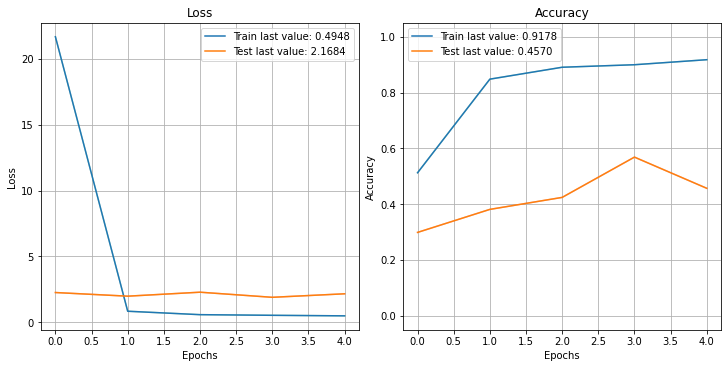

In [16]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=50)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [17]:
category_id_df = df[['Labels']].drop_duplicates().sort_values('Labels')
category_id_df

,Labels
10017,Aim
2056,Contribution
0,Defination
10125,Emperical Result
2018,Future work
3,Hypothesis
13,Hypothesis Result
9852,Method
9976,Motivation
662,Relation to literature


In [18]:
y_predict = model.predict(X_test)

In [19]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_predict)))

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0],
       [ 0, 23,  0,  0,  0,  0,  0,  0,  0, 34,  0,  0],
       [10,  0, 11,  0,  0,  0,  0,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 46,  0,  0],
       [ 0,  3,  1,  0, 29,  1,  0,  0,  0, 39,  6, 17],
       [15,  0,  7,  0,  0, 40,  0,  1,  1,  6,  0,  0],
       [ 0,  0,  0,  2,  0, 30,  1,  1,  0,  9,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0, 31,  0, 10,  1,  0],
       [ 8,  0,  0,  0,  0,  0,  0,  0, 10,  0,  6,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  6,  0, 26,  7, 12],
       [ 2,  0,  2,  0,  0,  0,  0,  0,  3,  1, 59,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0,  5,  1, 30]], dtype=int64)

In [20]:
from sklearn.metrics import confusion_matrix

Y_prediction = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

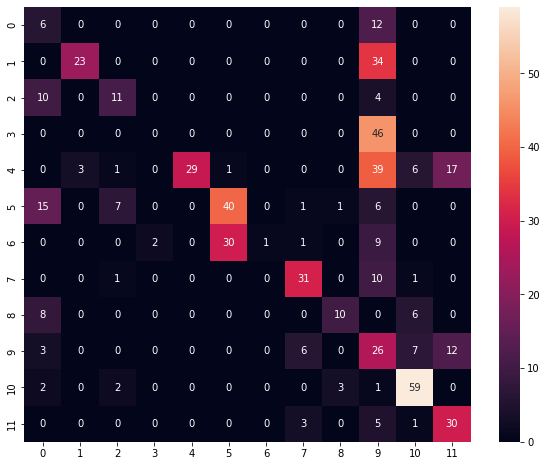

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

# HYPERPARAMETER TUNING

In [155]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(num_words, embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                           input_length=sequence_length,trainable=True))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu', kernel_regularizer=regularizers.l2(3)))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(12, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Main settings
epochs = 5
maxlen = sequence_length
model = KerasClassifier(build_fn=create_model,epochs=epochs, batch_size=50,verbose=False)

param_grid = dict(num_filters=[16, 32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[13501], 
                  embedding_dim=[200],
                  maxlen=[181],
                 )

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)
# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\nitis\AppData\Local\Temp/ipykernel_9496/4040403375.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model,epochs=epochs, batch_size=50,verbose=False)


Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best: 0.828156 using {'vocab_size': 13501, 'num_filters': 64, 'maxlen': 181, 'kernel_size': 3, 'embedding_dim': 200}
0.814607 (0.126261) with: {'vocab_size': 13501, 'num_filters': 128, 'maxlen': 181, 'kernel_size': 5, 'embedding_dim': 200}
0.814276 (0.124300) with: {'vocab_size': 13501, 'num_filters': 64, 'maxlen': 181, 'kernel_size': 7, 'embedding_dim': 200}
0.828156 (0.139791) with: {'vocab_size': 13501, 'num_filters': 64, 'maxlen': 181, 'kernel_size': 3, 'embedding_dim': 200}
0.825292 (0.141421) with: {'vocab_size': 13501, 'num_filters': 32, 'maxlen': 181, 'kernel_size': 5, 'embedding_dim': 200}
0.817471 (0.132545) with: {'vocab_size': 13501, 'num_filters': 16, 'maxlen': 181, 'kernel_size': 3, 'embedding_dim': 200}


In [156]:
print(grid_result.best_score_)
print(grid_result.best_params_)
print(test_accuracy)

0.828155979514122
{'vocab_size': 13501, 'num_filters': 64, 'maxlen': 181, 'kernel_size': 3, 'embedding_dim': 200}
0.4862543046474457
